# Part A
You should only need to run this once, after that can simply load in the saved images as done in part B.

In [18]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image, ImageOps

Image.MAX_IMAGE_PIXELS = None
import pandas as pd
import random
import numpy as np
import os
import sys
# import javabridge
# import bioformats

script_dir = os.path.dirname(os.path.realpath("__file__"))
data_dir = os.path.abspath(os.path.join(script_dir, "..", "..", "data_processed"))
dir_path = os.path.abspath(
    os.path.join(
        script_dir,
        "..",
        "..",
        "data_raw_big/Xenium_V1_FF_Mouse_Brain_MultiSection_1_outs",
    )
)
file_path = os.path.join(data_dir, "morphology_focus.tif")

In [19]:
%matplotlib widget

# Open the .tif file
img = Image.open(os.path.join(data_dir, "morphology_focus.tif"))
# img = Image.open(os.path.join(dir_path, "morphology_focus.tif"))


# Specify file paths
tif_file_path = "../data_processed/morphology_focus.tif"
ome_tif_file_path = "../data_raw/morphology_focus.ome.tif"

# # Check if the TIFF file already exists
# if not os.path.exists(tif_file_path):
#     # Start the JVM with additional memory
#     javabridge.start_vm(class_path=bioformats.JARS, max_heap_size="10G")

#     try:
#         # Read the OME-TIFF image
#         with bioformats.ImageReader(ome_tif_file_path) as reader:
#             img = reader.read()

#         # Normalize the image if necessary
#         img = img / 255.0  # Normalization, if needed

#         # Convert to PIL image and save as TIFF
#         pil_img = Image.fromarray((img * 255).astype("uint8"))  # Convert to 8-bit unsigned int
#         pil_img.save(tif_file_path, format="TIFF")

#     finally:
#         # Stop the JVM
#         javabridge.kill_vm()


# Convert to numpy array
image_array = np.array(img)

# Calculate the quantile to scale intensity
quantile_value = np.quantile(image_array, 0.99)

# Scale intensity by dividing by the quantile
scaled_image_array = image_array / quantile_value

# Clip values greater than 1 to ensure image is within [0, 1] range
img2 = np.clip(scaled_image_array, 0, 1)

# Display the scaled image
# plt.imshow(img2, cmap='gray')  # Uncomment this line and below to display the whole image (this runs slow)
# plt.show()

KeyboardInterrupt: 

In [ ]:
cell_boundaries = pd.read_csv(os.path.join(data_dir, "cell_boundaries.csv.gz"))
cell_boundaries["vertex_x_trans"] = cell_boundaries["vertex_x"].apply(
    lambda x: int(x / 0.2125)
)
cell_boundaries["vertex_y_trans"] = cell_boundaries["vertex_y"].apply(
    lambda x: int(x / 0.2125)
)

In [ ]:
clusters = pd.read_csv(os.path.join(data_dir, "clusters.csv"))
ncells = clusters.shape[0]
ncells

In [ ]:
img_pix = np.array(img)

In [ ]:
random.seed(2024)

ncells_subset = 1000

cells_subset = random.sample(range(ncells), ncells_subset)

clusters.loc[cells_subset, "Cluster"]

for i in range(
    1, ncells
):  # change range(1, ncells) to cells_subset (or the other way around) if you want a sample of 1000 images
    # extract the boundary vertices for the selected cell
    bounds_i = cell_boundaries.loc[cell_boundaries["cell_id"] == i]

    # extract the cluster value for the selected cell
    clustval_i = clusters.loc[i, "Cluster"]

    # extract the pixel intensities for the area covering the cell boundary
    img_sub = img_pix[
        min(bounds_i["vertex_y_trans"]) : max(bounds_i["vertex_y_trans"]),
        min(bounds_i["vertex_x_trans"]) : max(bounds_i["vertex_x_trans"]),
    ]

    # normalise the pixel intensities according to 99th percentile
    img_sub_norm = img_sub / np.quantile(img_sub, 0.99)

    # as an example, display the image for the first selected cell
    # if i in cells_subset[0:5]:
    #     print(f"Displaying image for cell {i}")
    # plt.imshow(img_sub_norm, cmap="gray")  # Uncomment this line and below to display sample cell images
    # plt.show()

    # create directory for images if it doesn't exist
    cell_dir = os.path.join(os.getcwd(), data_dir, "cell_images_py")
    if not os.path.exists(cell_dir):
        os.mkdir(cell_dir)

    # create directory for cluster if it doesn't exist
    clust_dir = os.path.join(cell_dir, f"cluster_{clustval_i}")
    if not os.path.exists(clust_dir):
        os.mkdir(clust_dir)

    # save extracted image as a png file
    plt.imsave(os.path.join(clust_dir, f"cell_{i}.png"), img_sub_norm, cmap="gray")

# Part B

### Setup

In [47]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image, ImageOps

Image.MAX_IMAGE_PIXELS = None
import pandas as pd
import random
import numpy as np
import os
import re

In [48]:
DATA_DIRECTORY = data_dir
CELL_IMAGES = os.path.join(DATA_DIRECTORY, "cell_images_py")
SIZE = (50, 50)

## Loading in and displaying images

In [49]:
def get_cluster_images(cluster: int, size=(None, None)):
    DIR = os.path.join(CELL_IMAGES, f"cluster_{cluster}")
    files = [os.path.join(DIR, file) for file in os.listdir(DIR)]
    files.sort()
    return [
        Image.open(file).convert("L")
        if None in size
        else Image.open(file).convert("L").resize(size)
        for file in files
    ]

In [50]:
# cluster_A_files = os.path.join(CELL_IMAGES, os.listdir(os.path.join(CELL_IMAGES, 'cluster_8')))
cluster_A_files = [
    os.path.join(os.path.join(CELL_IMAGES, "cluster_8"), file)
    for file in os.listdir(os.path.join(CELL_IMAGES, "cluster_8"))
]
cluster_B_files = [
    os.path.join(os.path.join(CELL_IMAGES, "cluster_13"), file)
    for file in os.listdir(os.path.join(CELL_IMAGES, "cluster_13"))
]

In [51]:
cluster_A_images = get_cluster_images(8)
cluster_B_images = get_cluster_images(13)
cluster_A_images_resized = get_cluster_images(8, size=SIZE)
cluster_B_images_resized = get_cluster_images(13, size=SIZE)

In [52]:
def display_images_in_grid(images, ncols=3, cmap=None):
    nrows = (len(images) + ncols - 1) // ncols
    fig_height = (
        nrows * 1
    )  # Adjust the multiplier as needed to control spacing between rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, fig_height))

    for ax in axes.flat:
        ax.axis("off")

    for i, image in enumerate(images):
        ax = axes[i // ncols, i % ncols]
        if not cmap:
            ax.imshow(image)
        else:
            ax.imshow(image, cmap=cmap)

    plt.subplots_adjust(wspace=0.01, hspace=0.03)  # Adjust spacing between subplots
    plt.show()


# display_images_in_grid(cluster_A_images_resized, ncols=10, cmap="gray")

## Cell boundary and masking

### Setup

In [53]:
from shapely.geometry import Polygon

# import rasterio
# from rasterio.features import geometry_mask
from skimage.draw import polygon2mask

In [54]:
cell_boundaries_raw = pd.read_csv("../../data_processed/cell_boundaries.csv.gz")


def get_cluster_cell_ids(cluster: int):
    DIR = os.path.join(CELL_IMAGES, f"cluster_{cluster}")
    files = [os.path.join(DIR, file) for file in os.listdir(DIR)]
    pattern = r"cell_(\d+)\.png"
    return [int(re.search(pattern, file).group(1)) for file in files]


cluster_A_cell_ids = get_cluster_cell_ids(8)
cluster_B_cell_ids = get_cluster_cell_ids(13)

### Masking one cell

In [55]:
cell_boundaries = cell_boundaries_raw.loc[
    cell_boundaries_raw["cell_id"].isin(cluster_A_cell_ids + cluster_B_cell_ids)
]

In [56]:
def get_masked_image(
    image: Image, cell_id: int, cell_boundaries: pd.core.frame.DataFrame
):
    height, width = np.array(image).shape
    cell_boundary = cell_boundaries[cell_boundaries["cell_id"] == cell_id].copy()
    cell_boundary["vertex_x_scaled"] = 1 + (
        (cell_boundary["vertex_x"] - cell_boundary["vertex_x"].min()) * scaling_factor
    )
    cell_boundary["vertex_y_scaled"] = 1 + (
        (cell_boundary["vertex_y"] - cell_boundary["vertex_y"].min()) * scaling_factor
    )
    polygon = np.array(
        list(zip(cell_boundary["vertex_y_scaled"], cell_boundary["vertex_x_scaled"]))
    )
    mask = polygon2mask((height, width), polygon)
    masked_image = np.ma.masked_array(np.copy(img_A), np.invert(mask), fill_value=0)
    return masked_image

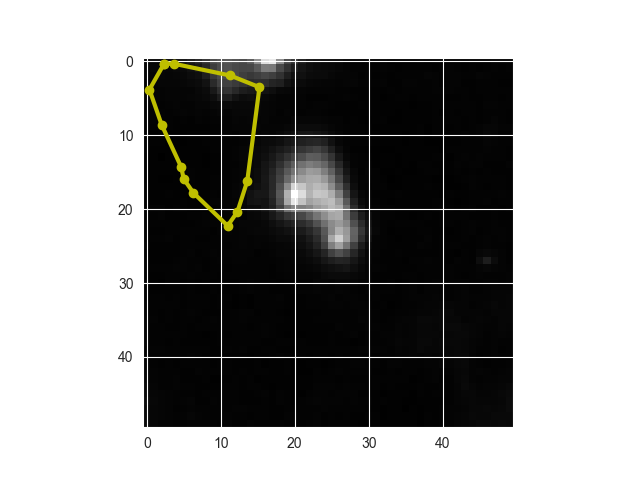

In [57]:
index = 0

cell_boundary = cell_boundaries[
    cell_boundaries["cell_id"] == cluster_A_cell_ids[index]
].copy()
img_A = cluster_A_images[index].convert("L")
img_A_resized = cluster_A_images_resized[index].convert("L")

# Calculate scaling factor
scaling_factor = 1 / 0.22
height, width = np.array(img_A).shape

# Calculate scaled x and y coordinates
cell_boundary["vertex_x_scaled"] = (
    (
        1
        + (
            (cell_boundary["vertex_x"] - cell_boundary["vertex_x"].min())
            * scaling_factor
        )
    )
    * 50
    / width
)
cell_boundary["vertex_y_scaled"] = (
    (
        1
        + (
            (cell_boundary["vertex_y"] - cell_boundary["vertex_y"].min())
            * scaling_factor
        )
    )
    * 50
    / height
)

# Visualize the image
plt.clf()
plt.close()
plt.imshow(img_A_resized, cmap="gray")
plt.plot(
    cell_boundary["vertex_x_scaled"],
    cell_boundary["vertex_y_scaled"],
    "y-o",
    linewidth=3,
)
plt.show()

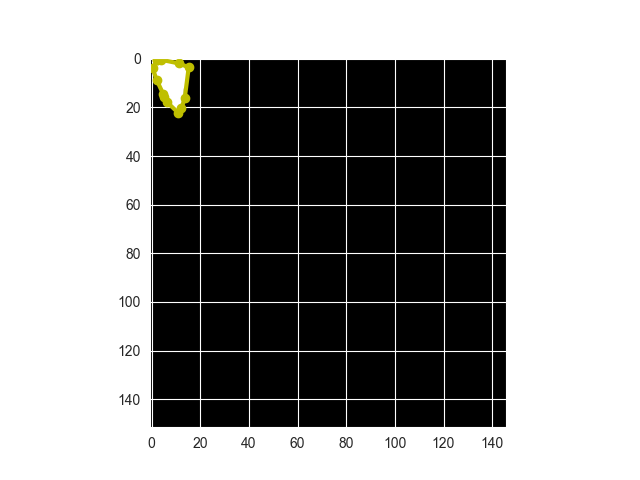

In [58]:
height, width = np.array(img_A.convert("L")).shape
polygon = np.array(
    list(zip(cell_boundary["vertex_y_scaled"], cell_boundary["vertex_x_scaled"]))
)
mask = polygon2mask((height, width), polygon)
masked_image = np.ma.masked_array(np.copy(img_A), np.invert(mask), fill_value=0)

# Display the masked image
# result = np.where(masked_image.mask, 0, masked_image)  # image with mask
result = np.where(masked_image.mask, 0, 1)  # just the mask
plt.imshow(result, cmap="gray")
plt.show()

### Masking all cells

In [59]:
def get_cluster_masked_images(cluster: int, size=(None, None), masked=False):
    images = get_cluster_images(cluster)
    if None not in size:  # get resized images if size is specified
        images_resized = get_cluster_images(cluster, size)

    cell_ids = get_cluster_cell_ids(cluster)
    cell_boundaries = cell_boundaries_raw.loc[
        cell_boundaries_raw["cell_id"].isin(cell_ids)
    ].copy()

    # Calculate scaling factor
    scaling_factor = 1 / 0.22

    result = {}
    for cell_id, image, image_resized in zip(cell_ids, images, images_resized):
        if masked:
            # get shape of original image (without resize)
            height, width = np.array(image).shape
            # scaling factor for cell boundary, only if size is given
            resize_x = 50 / width if None not in size else 1
            resize_y = 50 / height if None not in size else 1

            # get cell boundary coordinates for the image
            cell_boundary = cell_boundaries.loc[
                cell_boundaries["cell_id"] == cell_id
            ].copy()
            # Calculate scaled x and y coordinates
            cell_boundary["vertex_x_scaled"] = (
                1
                + (
                    (cell_boundary["vertex_x"] - cell_boundary["vertex_x"].min())
                    * scaling_factor
                )
            ) * resize_x
            cell_boundary["vertex_y_scaled"] = (
                1
                + (
                    (cell_boundary["vertex_y"] - cell_boundary["vertex_y"].min())
                    * scaling_factor
                )
            ) * resize_y

            # create the mask
            polygon = np.array(
                list(
                    zip(
                        cell_boundary["vertex_y_scaled"],
                        cell_boundary["vertex_x_scaled"],
                    )
                )
            )
            mask = polygon2mask((height, width) if None in size else SIZE, polygon)
            # mask the image
            masked_image = np.ma.masked_array(
                np.copy(image if None in size else image_resized),
                np.invert(mask),
                fill_value=0,
            )
            result[cell_id] = np.where(masked_image.mask, 0, masked_image)
        else:
            result[cell_id] = np.copy(image if None in size else image_resized)

    return result

In [60]:
masked_cells = {
    cluster: get_cluster_masked_images(cluster, size=SIZE, masked=True)
    for cluster in range(1, 29)
}

unmasked_cells = {
    cluster: get_cluster_masked_images(cluster, size=SIZE, masked=False)
    for cluster in range(1, 29)
}

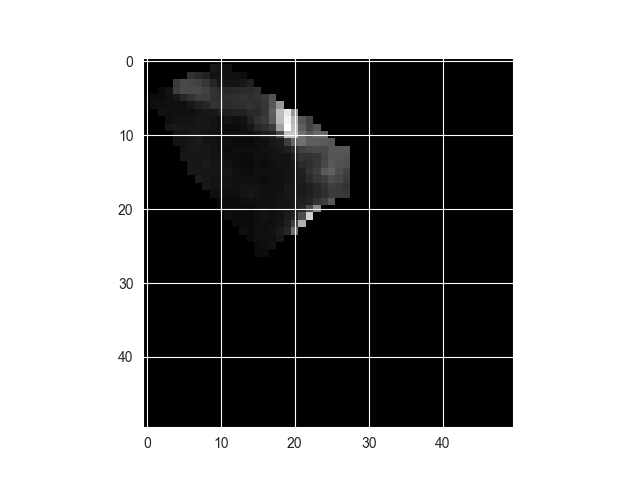

In [61]:
# display_images_in_grid(masked_cells[1])
cluster = 1
index = 3
plt.clf()
plt.close()
plt.imshow(
    masked_cells[cluster][list(unmasked_cells[cluster].keys())[index]], cmap="gray"
)
plt.show()

## Deep Learning

In [62]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

### Make the dataset

In [63]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np


class CustomDataset(Dataset):
    def __init__(self, images_dict, transform=None):
        self.images_dict = images_dict
        self.labels = []
        self.images = []
        for cluster, images in images_dict.items():
            self.images.extend(images.values())
            self.labels.extend([cluster - 1] * len(images))
        self.transform = transform  # Transformation to apply to each image

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Convert image to PyTorch tensor and normalize if necessary
        image_tensor = torch.tensor(image, dtype=torch.float32) / 255.0
        image_tensor = torch.unsqueeze(image_tensor, 0)
        if self.transform:
            image_tensor = self.transform(image_tensor)  # Apply transformation
        # Convert label to PyTorch tensor
        label_tensor = torch.tensor(label, dtype=torch.long)
        return image_tensor, label_tensor

In [64]:
import torch


def calculate_mean_std(images):
    # Initialize variables to accumulate the sum and sum of squares
    n_images = len(images)
    mean = torch.zeros(1)
    squared_sum = torch.zeros(1)

    for image in images:
        image_tensor = torch.tensor(image, dtype=torch.float32) / 255.0
        mean += torch.mean(image_tensor)
        squared_sum += torch.mean(image_tensor**2)

    # Calculate mean and standard deviation
    mean /= n_images
    std = torch.sqrt(squared_sum / n_images - mean**2)

    return mean.item(), std.item()


mean, std = calculate_mean_std(unmasked_cells)

#### Load data and create dataloaders

In [65]:
from torchvision.transforms import AutoAugmentPolicy
from torchvision import transforms

train_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
        transforms.RandomRotation(50),
        transforms.RandomResizedCrop(50, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(
            [
                mean,
            ],
            [
                std,
            ],
        ),  # Normalize the image
    ]
)
custom_dataset = CustomDataset(unmasked_cells, train_transforms)

# Define the sizes of the training, validation, and testing sets
train_size = int(0.6 * len(custom_dataset))  # 60% for training
val_size = int(0.2 * len(custom_dataset))  # 20% for validation
test_size = len(custom_dataset) - train_size - val_size  # Remaining for testing

# Split the dataset into training, validation, and testing sets
train_dataset, val_dataset, test_dataset = random_split(
    custom_dataset, [train_size, val_size, test_size]
)

# Define batch size and other DataLoader parameters
batch_size = 32
shuffle = True

# Create DataLoader for training set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

# Create DataLoader for validation set
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create DataLoader for testing set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Make the models

#### Random simple model

In [66]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1
        )
        self.fc1 = nn.Linear(
            64 * 6 * 6, 128
        )  # Adjust input size based on your image size
        self.fc2 = nn.Linear(128, num_classes)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)

        x = x.view(-1, 64 * 6 * 6)  # Adjust input size based on your image size
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Lab 4b Model

In [67]:
class LabModel(nn.Module):
    def __init__(self):
        super(LabModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding=1
        )
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(
            64 * 12 * 12, 128
        )  # Adjust input size based on your image size
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(64, 28)  # Assuming 2 classes for binary classification

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(-1, 64 * 12 * 12)  # Adjust input size based on your image size
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout2(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.dropout3(x)
        x = self.fc3(x)
        return x

#### AlexNet

In [68]:
class AlexNet(nn.Module):
    def __init__(self, num=28):
        super(AlexNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32 * 12 * 12, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num),
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(-1, 32 * 12 * 12)
        return self.classifier(x)
        # return x

In [69]:
# Define the ResNet model
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F


class ModifiedResNet50(models.ResNet):
    def __init__(self, weights=None, num_classes=28, *args, **kwargs):
        super(ModifiedResNet50, self).__init__(
            block=models.resnet.Bottleneck, layers=[3, 4, 6, 3], *args, **kwargs
        )

        # Initialize a new fully connected layer with the correct number of classes
        self.fc = nn.Linear(2048, num_classes)

        # If weights is provided, load the state_dict with strict=False to avoid errors
        if weights is not None:
            state_dict = weights.state_dict()

            # Remove the weights related to the fully connected layer to avoid mismatch
            if "fc.weight" in state_dict and "fc.bias" in state_dict:
                del state_dict["fc.weight"]
                del state_dict["fc.bias"]

            self.load_state_dict(state_dict, strict=False)

        # Modify the first convolutional layer to accept 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Update the first layer's weights, if weights were provided
        if weights is not None:
            with torch.no_grad():
                original_first_layer = state_dict["conv1.weight"]
                self.conv1.weight.data = original_first_layer.mean(dim=1, keepdim=True)

        # Adding Dropout
        self.dropout = nn.Dropout(0.5)

        # Adding Batch Normalization
        self.bn1 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [70]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F


class ModifiedResNet18(models.ResNet):
    def __init__(self, weights=None, num_classes=28, *args, **kwargs):
        super(ModifiedResNet18, self).__init__(
            block=models.resnet.BasicBlock, layers=[2, 2, 2, 2], *args, **kwargs
        )

        # Initialize a new fully connected layer with the correct number of classes
        self.fc = nn.Linear(512, num_classes)

        # If weights is provided, load the state_dict with strict=False to avoid errors
        if weights is not None:
            state_dict = weights.state_dict()

            # Remove the weights related to the fully connected layer to avoid mismatch
            if "fc.weight" in state_dict and "fc.bias" in state_dict:
                del state_dict["fc.weight"]
                del state_dict["fc.bias"]

            self.load_state_dict(state_dict, strict=False)

        # Modify the first convolutional layer to accept 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Update the first layer's weights, if weights were provided
        if weights is not None:
            with torch.no_grad():
                original_first_layer = state_dict["conv1.weight"]
                self.conv1.weight.data = original_first_layer.mean(dim=1, keepdim=True)

        # Adding Dropout
        self.dropout = nn.Dropout(0.5)

        # Adding Batch Normalization
        self.bn1 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [71]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F


# Define a modified Vision Transformer (ViT) with a dropout layer
class ModifiedViT(nn.Module):
    def __init__(
        self,
        model_name="vit_base_patch16_224",
        pretrained=True,
        num_classes=1000,
        dropout_rate=0.3,  # Default dropout rate
    ):
        super(ModifiedViT, self).__init__()

        # Load the pretrained ViT model
        self.vit = timm.create_model(
            model_name, pretrained=pretrained, num_classes=num_classes
        )

        # Modify the patch embedding to handle grayscale images
        original_patch_embedding = self.vit.patch_embed.proj
        self.vit.patch_embed.proj = nn.Conv2d(
            1,
            original_patch_embedding.out_channels,
            kernel_size=original_patch_embedding.kernel_size,
            stride=original_patch_embedding.stride,
            padding=original_patch_embedding.padding,
            bias=False,
        )

        # If using pretrained weights, adjust for grayscale
        if pretrained:
            with torch.no_grad():
                original_weight = original_patch_embedding.weight.mean(
                    dim=1, keepdim=True
                )
                self.vit.patch_embed.proj.weight.data = original_weight

        # Add dropout layer after patch embedding
        self.dropout = nn.Dropout(p=dropout_rate)

        # Replace the classifier head
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)

    def forward(self, x):
        x = self.vit.patch_embed(x)

        cls_token = self.vit.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        # Apply positional dropout and add positional embedding
        x = self.vit.pos_drop(x + self.vit.pos_embed)

        # Apply dropout before entering transformer blocks
        x = self.dropout(x)

        # Forward through the transformer blocks
        x = self.vit.blocks(x)

        # Apply normalization
        x = self.vit.norm(x)

        # Select CLS token and apply final dropout
        x = self.dropout(x[:, 0])

        # Final classifier head
        x = self.vit.head(x)

        return x

### Train

In [72]:
from tqdm import tqdm
import torch
import torch.nn as nn


def train_model(
    model, train_loader, val_loader, num_epochs=100, learning_rate=0.0001, save_path=None,*args,**kwargs    
):
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Move the model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.clear_autocast_cache()
    model.to(device)

    # Store training and validation loss and accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Progress bar for inner training loop
        with tqdm(
            train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False
        ) as pbar:
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass and backward pass with optimization
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Accumulate loss and accuracy
                running_train_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                # Update the progress bar with training loss and accuracy
                pbar.set_postfix(
                    {
                        "train_loss": running_train_loss / total_train,
                        "accuracy": correct_train / total_train,
                    }
                )

        # Calculate average training loss and accuracy for the epoch
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_accuracy = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Validation loop
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Accumulate loss and accuracy
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        # Save the model state
        if save_path:
            model_save_path = os.path.join(save_path, f"model_epoch_{epoch + 1}.pth")
            torch.save(model.state_dict(), model_save_path)

        # Optional: Print a summary at the end of each epoch
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, "
            f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}"
        )

    # Return training and validation losses and accuracies
    return train_losses, val_losses, train_accuracies, val_accuracies

In [31]:
for images, labels in train_loader:
    print(images.size())
    break

torch.Size([32, 1, 50, 50])


In [80]:
save_path = os.path.join(script_dir, "models")
model = ModifiedResNet50()
t_loss, v_loss, t_acc, v_acc = train_model(
    model, train_loader, val_loader, num_epochs=50, save_path=save_path
)
lab_model_results = {"t_loss": t_loss, "v_loss": v_loss, "t_acc": t_acc, "v_acc": v_acc}

Epoch [1/50], Train Loss: 3.1378, Train Accuracy: 0.1014, Val Loss: 3.0921, Val Accuracy: 0.1164


Epoch [2/50], Train Loss: 3.0989, Train Accuracy: 0.1112, Val Loss: 3.0451, Val Accuracy: 0.1167


Epoch [3/50], Train Loss: 3.0637, Train Accuracy: 0.1216, Val Loss: 3.0587, Val Accuracy: 0.1140


Epoch [4/50], Train Loss: 3.0393, Train Accuracy: 0.1274, Val Loss: 3.0222, Val Accuracy: 0.1384


Epoch [5/50], Train Loss: 3.0286, Train Accuracy: 0.1334, Val Loss: 3.0073, Val Accuracy: 0.1386


Epoch [6/50], Train Loss: 3.0167, Train Accuracy: 0.1302, Val Loss: 2.9988, Val Accuracy: 0.1189


Epoch [7/50], Train Loss: 3.0071, Train Accuracy: 0.1347, Val Loss: 2.9997, Val Accuracy: 0.1476


Epoch [8/50], Train Loss: 3.0043, Train Accuracy: 0.1374, Val Loss: 2.9860, Val Accuracy: 0.1454


Epoch [9/50], Train Loss: 2.9956, Train Accuracy: 0.1390, Val Loss: 2.9713, Val Accuracy: 0.1423


Epoch [10/50], Train Loss: 2.9850, Train Accuracy: 0.1429, Val Loss: 2.9582, Val Accuracy: 0.1494


Epoch [11/50], Train Loss: 2.9673, Train Accuracy: 0.1486, Val Loss: 2.9481, Val Accuracy: 0.1532


Epoch [12/50], Train Loss: 2.9470, Train Accuracy: 0.1529, Val Loss: 2.9354, Val Accuracy: 0.1621


Epoch [13/50], Train Loss: 2.9386, Train Accuracy: 0.1533, Val Loss: 2.9148, Val Accuracy: 0.1624


Epoch [14/50], Train Loss: 2.9234, Train Accuracy: 0.1558, Val Loss: 2.9014, Val Accuracy: 0.1622


Epoch [15/50], Train Loss: 2.9175, Train Accuracy: 0.1592, Val Loss: 2.9042, Val Accuracy: 0.1635


Epoch [16/50], Train Loss: 2.9097, Train Accuracy: 0.1604, Val Loss: 2.8852, Val Accuracy: 0.1659


Epoch [17/50], Train Loss: 2.8987, Train Accuracy: 0.1633, Val Loss: 2.8858, Val Accuracy: 0.1700


Epoch [18/50], Train Loss: 2.8922, Train Accuracy: 0.1617, Val Loss: 2.8864, Val Accuracy: 0.1602


Epoch [19/50], Train Loss: 2.8871, Train Accuracy: 0.1644, Val Loss: 2.8743, Val Accuracy: 0.1668


Epoch [20/50], Train Loss: 2.8845, Train Accuracy: 0.1688, Val Loss: 2.8661, Val Accuracy: 0.1755


Epoch [21/50], Train Loss: 2.8799, Train Accuracy: 0.1688, Val Loss: 2.8685, Val Accuracy: 0.1721


Epoch [22/50], Train Loss: 2.8769, Train Accuracy: 0.1686, Val Loss: 2.8610, Val Accuracy: 0.1724


Epoch [23/50], Train Loss: 2.8715, Train Accuracy: 0.1709, Val Loss: 2.8479, Val Accuracy: 0.1732


Epoch [24/50], Train Loss: 2.8653, Train Accuracy: 0.1704, Val Loss: 2.8527, Val Accuracy: 0.1732


Epoch [25/50], Train Loss: 2.8643, Train Accuracy: 0.1697, Val Loss: 2.8539, Val Accuracy: 0.1748


Epoch [26/50], Train Loss: 2.8570, Train Accuracy: 0.1705, Val Loss: 2.8469, Val Accuracy: 0.1777


Epoch [27/50], Train Loss: 2.8550, Train Accuracy: 0.1720, Val Loss: 2.8581, Val Accuracy: 0.1793


Epoch [28/50], Train Loss: 2.8536, Train Accuracy: 0.1718, Val Loss: 2.8428, Val Accuracy: 0.1737


Epoch [29/50], Train Loss: 2.8474, Train Accuracy: 0.1731, Val Loss: 2.8384, Val Accuracy: 0.1773


Epoch [30/50], Train Loss: 2.8424, Train Accuracy: 0.1810, Val Loss: 2.8389, Val Accuracy: 0.1789


Epoch [31/50], Train Loss: 2.8423, Train Accuracy: 0.1768, Val Loss: 2.8438, Val Accuracy: 0.1758


Epoch [32/50], Train Loss: 2.8360, Train Accuracy: 0.1764, Val Loss: 2.8483, Val Accuracy: 0.1731


Epoch [33/50], Train Loss: 2.8388, Train Accuracy: 0.1787, Val Loss: 2.8349, Val Accuracy: 0.1756


Epoch [34/50], Train Loss: 2.8325, Train Accuracy: 0.1793, Val Loss: 2.8354, Val Accuracy: 0.1759


Epoch [35/50], Train Loss: 2.8301, Train Accuracy: 0.1795, Val Loss: 2.8306, Val Accuracy: 0.1791


Epoch [36/50], Train Loss: 2.8253, Train Accuracy: 0.1838, Val Loss: 2.8345, Val Accuracy: 0.1759


Epoch [37/50], Train Loss: 2.8199, Train Accuracy: 0.1839, Val Loss: 2.8288, Val Accuracy: 0.1865


Epoch [38/50], Train Loss: 2.8232, Train Accuracy: 0.1818, Val Loss: 2.8231, Val Accuracy: 0.1810


Epoch [39/50], Train Loss: 2.8145, Train Accuracy: 0.1817, Val Loss: 2.8320, Val Accuracy: 0.1830


Epoch [40/50], Train Loss: 2.8123, Train Accuracy: 0.1862, Val Loss: 2.8383, Val Accuracy: 0.1767


Epoch [41/50], Train Loss: 2.8115, Train Accuracy: 0.1835, Val Loss: 2.8298, Val Accuracy: 0.1840


Epoch [42/50], Train Loss: 2.8048, Train Accuracy: 0.1846, Val Loss: 2.8408, Val Accuracy: 0.1810


Epoch [43/50], Train Loss: 2.8066, Train Accuracy: 0.1857, Val Loss: 2.8309, Val Accuracy: 0.1822


Epoch [44/50], Train Loss: 2.8019, Train Accuracy: 0.1855, Val Loss: 2.8253, Val Accuracy: 0.1866


Epoch [45/50], Train Loss: 2.8021, Train Accuracy: 0.1874, Val Loss: 2.8171, Val Accuracy: 0.1836


Epoch [46/50], Train Loss: 2.7935, Train Accuracy: 0.1866, Val Loss: 2.8234, Val Accuracy: 0.1836


Epoch [47/50], Train Loss: 2.7916, Train Accuracy: 0.1894, Val Loss: 2.8244, Val Accuracy: 0.1821


Epoch [48/50], Train Loss: 2.7922, Train Accuracy: 0.1907, Val Loss: 2.8195, Val Accuracy: 0.1819


Epoch [49/50], Train Loss: 2.7851, Train Accuracy: 0.1897, Val Loss: 2.8212, Val Accuracy: 0.1828


Epoch [50/50], Train Loss: 2.7829, Train Accuracy: 0.1904, Val Loss: 2.8186, Val Accuracy: 0.1828


In [45]:
def generate_plots(train_losses, val_losses, train_accuracies, val_accuracies):
    with plt.style.context("dark_background"):
        # Generate x-axis values (epochs)
        epochs = range(1, len(train_losses) + 1)

        # Create subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

        # Plot training and validation losses
        ax1.plot(epochs, train_losses, label="Training Loss", marker="o")
        ax1.plot(epochs, val_losses, label="Validation Loss", marker="o")

        # Add jitter to the data points for better visualization
        ax1.scatter(epochs, train_losses, color="blue")
        ax1.scatter(epochs, val_losses, color="orange")

        # Add labels and legend for the first subplot
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.set_title("Training and Validation Loss")
        ax1.legend()

        # Plot training and validation accuracies
        ax2.plot(epochs, train_accuracies, label="Training Accuracy", marker="o")
        ax2.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o")

        # Add jitter to the data points for better visualization
        ax2.scatter(epochs, train_accuracies, color="green")
        ax2.scatter(epochs, val_accuracies, color="red")

        # Add labels and legend for the second subplot
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Accuracy")
        ax2.set_title("Training and Validation Accuracy")
        ax2.legend()

        # Adjust layout
        plt.tight_layout()

        # Show plot
        plt.show()

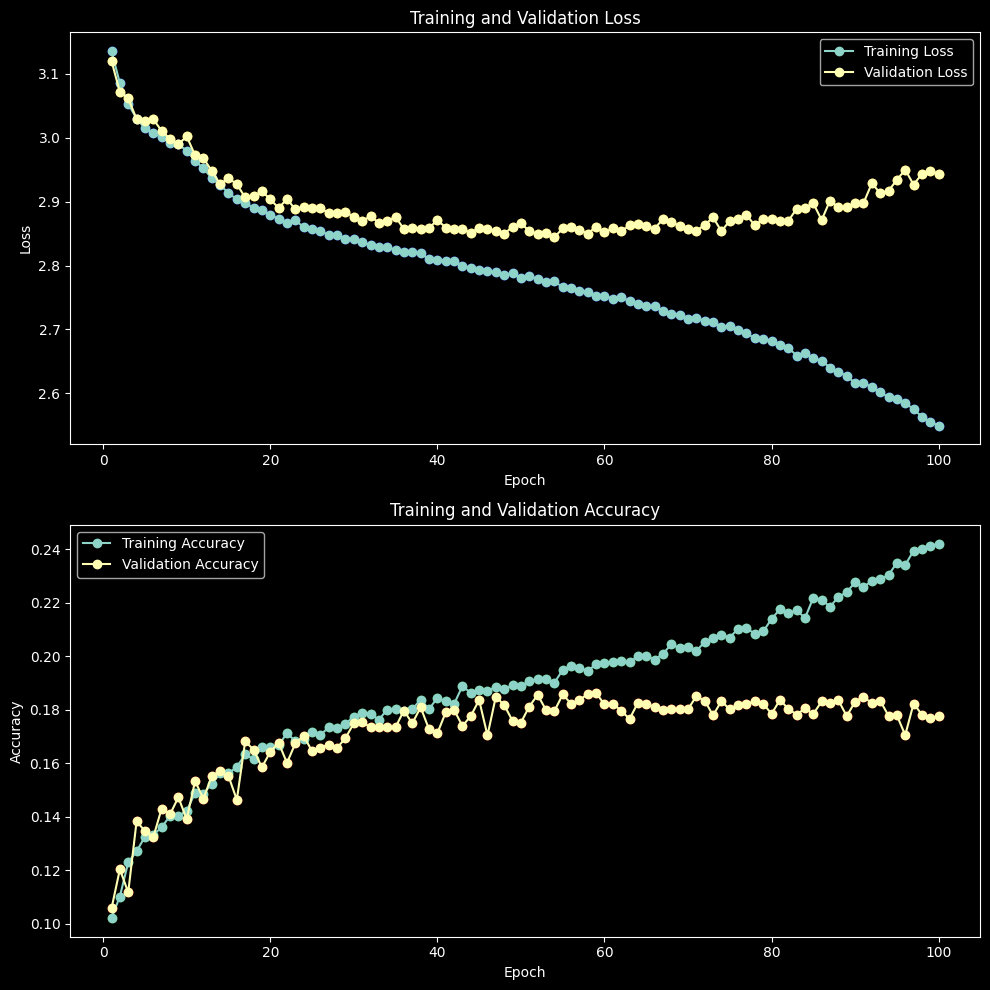

In [34]:
generate_plots(
    lab_model_results["t_loss"],
    lab_model_results["v_loss"],
    lab_model_results["t_acc"],
    lab_model_results["v_acc"],
)

Evaluation func

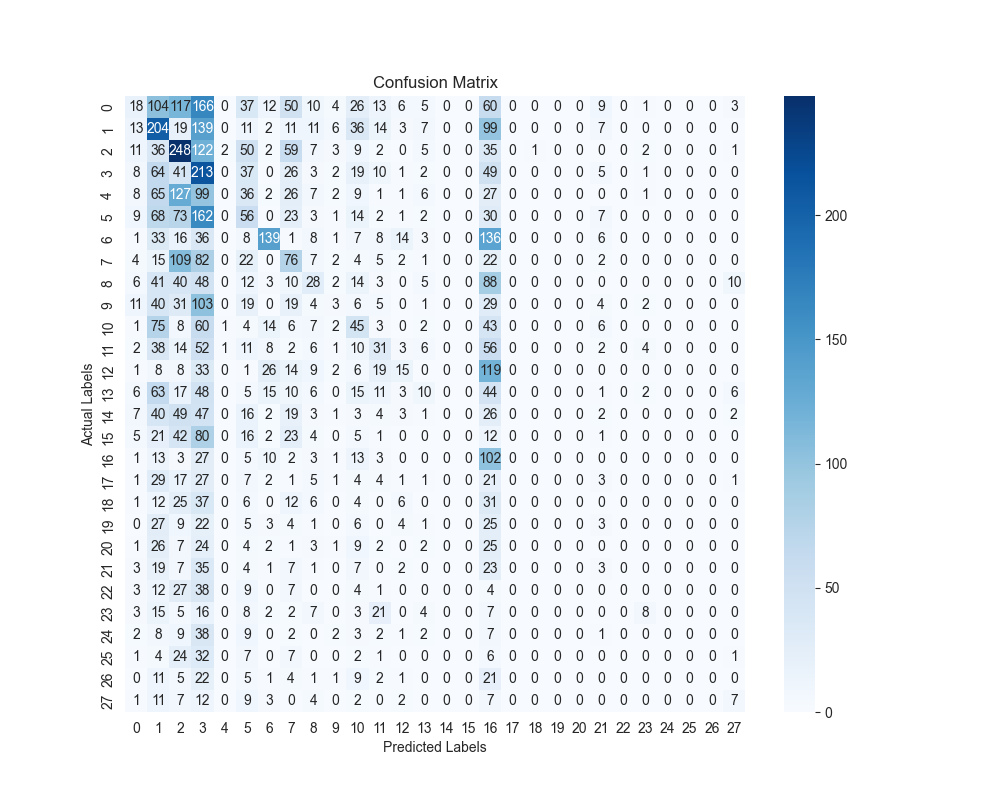

{'Accuracy': 0.1649794801641587, 'Precision': 0.14770202277724112, 'Recall': 0.1649794801641587, 'F1 Score': 0.13021732531163852, 'Adjusted Rand Index': 0.03148553765352086, 'Precision by cluster': array([0.140625  , 0.18511797, 0.22463768, 0.11703297, 0.        ,
       0.13365155, 0.55378486, 0.17924528, 0.18181818, 0.07894737,
       0.15306122, 0.18452381, 0.2173913 , 0.15151515, 0.        ,
       0.        , 0.08838821, 0.        , 0.        , 0.        ,
       0.        , 0.0483871 , 0.        , 0.38095238, 0.        ,
       0.        , 0.        , 0.22580645]), 'Recall by cluster': array([0.02808112, 0.35051546, 0.41680672, 0.44282744, 0.        ,
       0.12416851, 0.33333333, 0.21529745, 0.09032258, 0.01083032,
       0.16245487, 0.12550607, 0.05747126, 0.03816794, 0.        ,
       0.        , 0.55737705, 0.        , 0.        , 0.        ,
       0.        , 0.02678571, 0.        , 0.07920792, 0.        ,
       0.        , 0.        , 0.10769231]), 'F1 score by cluster'

In [93]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, accuracy_score, precision_recall_fscore_support, confusion_matrix

def evaluate_model_clusters(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    predictions, true_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted_labels = outputs.argmax(1)
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Metrics calculation
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    ari = adjusted_rand_score(true_labels, predictions)
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average=None, zero_division=0)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted', zero_division=0)

    # Confusion Matrix and Heatmap
    conf_mat = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.show()
    
    return {
        "Accuracy": accuracy,
        "Precision": precision_weighted,
        "Recall": recall_weighted,
        "F1 Score": f1_weighted,
        "Adjusted Rand Index": ari,
        "Precision by cluster":precision,
        "Recall by cluster":recall,
        "F1 score by cluster":f1
    }

# Assuming model and val_loader are already defined
model = ModifiedResNet50()
model.load_state_dict(torch.load(os.path.join(save_path,"model_epoch_50.pth")))
metrics = evaluate_model_clusters(model, val_loader)
print(metrics)
